# Assignment 6

In this assignment, you'll analyze a collection of data sets from the [San Francisco Open Data Portal](http://data.sfgov.org/) and [Zillow](https://www.zillow.com/). The data sets have been stored in the SQLite database `sf_data.sqlite`, which you can [download here](http://anson.ucdavis.edu/~nulle/sf_data.sqlite). The database contains the following tables:

Table                   | Description
----------------------- | -----------
`crime`                 | Crime reports dating back to 2010.
`mobile_food_locations` | List of all locations where mobile food vendors sell.
`mobile_food_permits`   | List of all mobile food vendor permits. More details [here](https://data.sfgov.org/api/views/rqzj-sfat/files/8g2f5RV4PEk0_b24iJEtgEet9gnh_eA27GlqoOjjK4k?download=true&filename=DPW_DataDictionary_Mobile-Food-Facility-Permit.pdf).
`mobile_food_schedule`  | Schedules for mobile food vendors.
`noise`                 | Noise complaints dating back to August 2015.
`parking`               | List of all parking lots.
`parks`                 | List of all parks.
`schools`               | List of all schools.
`zillow`                | Zillow rent and housing statistics dating back to 1996. More details [here](https://www.zillow.com/research/data/).

The `mobile_food_` tables are explicitly connected through the `locationid` and `permit` columns. The other tables are not connected, but you may be able to connect them using dates, latitude/longitude, or postal codes.

Shapefiles for US postal codes are available [here](https://www.census.gov/geo/maps-data/data/cbf/cbf_zcta.html). These may be useful for converting latitude/longitude to postal codes.

Shapefiles for San Francisco Neighborhoods are available [here](https://data.sfgov.org/Geographic-Locations-and-Boundaries/SF-Find-Neighborhoods/pty2-tcw4).

__Exercise 1.1.__ Which mobile food vendor(s) sells at the most locations?

In [21]:
import pandas as pd
from matplotlib import pyplot as plt
import sqlalchemy as sqla
import sqlite3
%matplotlib inline
plt.style.use('ggplot')

In [22]:
conn0 = sqlite3.connect('sf_data.sqlite')

In [23]:
c = conn0.cursor()

In [24]:
c.execute("""select * from mobile_food_locations""")
c.fetchone()

(762182,
 u'TOWNSEND ST: 05TH ST to 06TH ST (400 - 499)',
 u'444 TOWNSEND ST',
 37.7748713162388,
 -122.39853170827601)

In [25]:
c.execute("""select * from mobile_food_permits""")
c.fetchone()

(u'16MFF-0027',
 u'APPROVED',
 u'F & C Catering',
 u'Truck',
 u'Cold Truck: Hot/Cold Sandwiches: Water: Soda: Juice: Snacks: Milk: Candies: Canned Food: Soups: Cup of Noodles: Fruit: Salad',
 1,
 u'2016-03-09 12:00:00',
 u'2017-03-15 12:00:00')

In [26]:
c.description

(('permit', None, None, None, None, None, None),
 ('Status', None, None, None, None, None, None),
 ('Applicant', None, None, None, None, None, None),
 ('FacilityType', None, None, None, None, None, None),
 ('FoodItems', None, None, None, None, None, None),
 ('PriorPermit', None, None, None, None, None, None),
 ('Approved', None, None, None, None, None, None),
 ('Expiration', None, None, None, None, None, None))

In [31]:
pd.read_sql_query("""select * from mobile_food_permits where Applicant = 'Liang Bai Ping' """, conn0)

,permit,Status,Applicant,FacilityType,FoodItems,PriorPermit,Approved,Expiration
0,17MFF-0090,REQUESTED,Liang Bai Ping,Truck,Cold Truck: Pre-packaged sandwiches: snacks: f...,1,None,2018-03-17 12:00:00


In [299]:
pd.read_sql_query("""select "permit","Status","Applicant","FacilityType",count(*) as "loc.number" from
(select * from mobile_food_schedule join mobile_food_permits 
on mobile_food_schedule."permit" = mobile_food_permits."permit")
group by "permit"
order by "loc.number" desc
""", conn0).iloc[0:10]

,permit,Status,Applicant,FacilityType,loc.number
0,17MFF-0110,REQUESTED,May Catering,Truck,340
1,13MFF-0102,EXPIRED,Natan's Catering,Truck,221
2,17MFF-0111,REQUESTED,Anas Goodies Catering,Truck,212
3,17MFF-0090,REQUESTED,Liang Bai Ping,Truck,182
4,14MFF-0109,EXPIRED,Mang Hang Catering,Truck,165
5,16MFF-0051,APPROVED,Park's Catering,Truck,134
6,17MFF-0091,REQUESTED,Steve's Mobile Deli,Truck,125
7,17MFF-0084,REQUESTED,John's Catering #5,Truck,120
8,16MFF-0048,REQUESTED,Singh Brothers Ice Cream,Truck,105
9,14MFF-0001,EXPIRED,Sun Rise Catering,Truck,100


In [300]:
pd.read_sql_query("""select "permit","Status","FacilityType","Applicant",count(*) as "loc.number" from
(select * from mobile_food_schedule join mobile_food_permits 
on mobile_food_schedule."permit" = mobile_food_permits."permit"
where mobile_food_permits.Status =='APPROVED')
group by "permit"
order by "loc.number" desc
""", conn0).iloc[0:10]

,permit,Status,FacilityType,Applicant,loc.number
0,16MFF-0051,APPROVED,Truck,Park's Catering,134
1,16MFF-0037,APPROVED,Truck,D & T Catering,85
2,16MFF-0027,APPROVED,Truck,F & C Catering,79
3,16MFF-0069,APPROVED,Truck,Munch A Bunch,52
4,17MFF-0125,APPROVED,Truck,BH & MT LLC,40
5,16MFF-0019,APPROVED,Truck,Linda's Catering,35
6,16MFF-0047,APPROVED,Truck,Golden Catering,31
7,16MFF-0053,APPROVED,Truck,Eva's Catering,19
8,16MFF-0096,APPROVED,Truck,Subs on Hubs,19
9,16MFF-0032,APPROVED,Truck,Tacos Rodriguez,17


May's Catering whose permit is 17MFF-0110 sells in most places after it is permitted by the authority.

Parks' Catering whose permit is 16MFF-0051 sells in most places currently.

__Exercise 1.2.__ Ask and use the database to analyze 5 questions about San Francisco. For each question, write at least 150 words and support your answer with plots. Make a map for at least 2 of the 5 questions.

You should try to come up with some questions on your own, but these are examples of reasonable questions:

* Which parts of the city are the most and least expensive?
* Which parts of the city are the most dangerous (and at what times)?
* Are noise complaints and mobile food vendors related?
* What are the best times and places to find food trucks?
* Is there a relationship between housing prices and any of the other tables?

Please make sure to clearly state each of your questions in your submission.

In [8]:
from mpl_toolkits.basemap import Basemap
import matplotlib.pyplot as plt
import scipy.stats as ss
import numpy as np
from matplotlib.patches import Circle, Wedge, Polygon
from matplotlib.colors import LinearSegmentedColormap
import geopandas as gpd

**1.2.1**-Which parts of the city are the most and least expensive?

I found the the most and least expensive by making a pandas table "avgHprice" that sorted the averaging ZriPerSqft_AllHomes and MedianSoldPricePerSqft_AllHomes in Table Zillow after groupby RegionName. Based on the table "avgHprice", then I made a scatter plot of the four variables in the avgHprice table, and marking "RegionName" to few points that have the max and min values in each variables. 
Such that, I found that the most expensive "RegionName" by Medium Sold Price is **94104**. 

However, other data for this region is missing. So considering other variables, the most expensive "RegionName" is 94105, and least expensive "RegionName" are 94124. To check the results, I mapped the avgerage values of four variables in each region, the map also supported results.

Relatively, 94105 have highest ZriPerSqft_AllHomes, MedianSoldPricePerSqft_AllHomes and Turnover, though the PricetoRentRatio is not the highest. 

Relatively, 94124 have the lowest ZriPerSqft_AllHomes, MedianSoldPricePerSqft_AllHomes and Turnover, though the PricetoRentRatio is at an average level. 

In [5]:
c.execute("""select * from zillow
""")
c.fetchone() #zipcode, time, 

(94109, u'2010-11-01 00:00:00', 3.156, 675.1913, 19.14, 6.0771)

In [10]:
Hprice = pd.read_sql_query("select * from zillow",conn0)
Hprice.describe()

/Users/wuruolai/anaconda/lib/python2.7/site-packages/numpy/lib/function_base.py:3834: RuntimeWarning: Invalid value encountered in percentile
  RuntimeWarning)


,RegionName,ZriPerSqft_AllHomes,MedianSoldPricePerSqft_AllHomes,PriceToRentRatio_AllHomes,Turnover_AllHomes
count,6500.000000,1875.000000,4236.000000,1824.000000,5748.000000
mean,94116.769231,3.168945,525.730531,20.288761,5.556529
std,14.338541,0.854484,219.288139,2.925694,3.037575
min,94080.000000,1.666000,103.938000,10.860000,1.459900
25%,94108.000000,NaN,NaN,NaN,NaN
50%,94115.500000,NaN,NaN,NaN,NaN
75%,94124.000000,NaN,NaN,NaN,NaN
max,94158.000000,5.284000,1336.128581,30.250000,37.162200


In [11]:
avgHprice = Hprice.groupby(['RegionName'])['RegionName','ZriPerSqft_AllHomes','MedianSoldPricePerSqft_AllHomes'
                                     ,'PriceToRentRatio_AllHomes','Turnover_AllHomes'].mean()
avgHprice.head()

,RegionName,ZriPerSqft_AllHomes,MedianSoldPricePerSqft_AllHomes,PriceToRentRatio_AllHomes,Turnover_AllHomes
RegionName,,,,,
94080,94080,2.172000,375.629802,18.342105,4.413822
94102,94102,3.984933,626.417276,16.411053,6.538972
94103,94103,3.679040,604.009929,17.654868,7.188214
94104,94104,NaN,1336.128581,NaN,14.831512
94105,94105,4.279173,798.257824,20.133816,6.928359


In [18]:
avgHprice.sort_values(['ZriPerSqft_AllHomes'], ascending=0).head()

,RegionName,ZriPerSqft_AllHomes,MedianSoldPricePerSqft_AllHomes,PriceToRentRatio_AllHomes,Turnover_AllHomes
RegionName,,,,,
94105,94105,4.279173,798.257824,20.133816,6.928359
94108,94108,4.149920,501.013201,18.649474,6.620130
94102,94102,3.984933,626.417276,16.411053,6.538972
94133,94133,3.898693,638.636839,21.344474,5.647622
94109,94109,3.852080,618.325709,19.251316,6.579195


In [19]:
avgHprice.sort_values(['MedianSoldPricePerSqft_AllHomes'], ascending=0).head()

,RegionName,ZriPerSqft_AllHomes,MedianSoldPricePerSqft_AllHomes,PriceToRentRatio_AllHomes,Turnover_AllHomes
RegionName,,,,,
94104,94104,NaN,1336.128581,NaN,14.831512
94105,94105,4.279173,798.257824,20.133816,6.928359
94123,94123,3.764773,696.166788,26.086711,5.839732
94158,94158,3.720693,657.211820,19.415789,11.872355
94114,94114,3.359920,650.127729,23.930658,5.647630


In [20]:
avgHprice.sort_values(['PriceToRentRatio_AllHomes'], ascending=0).head()

,RegionName,ZriPerSqft_AllHomes,MedianSoldPricePerSqft_AllHomes,PriceToRentRatio_AllHomes,Turnover_AllHomes
RegionName,,,,,
94123,94123,3.764773,696.166788,26.086711,5.839732
94114,94114,3.359920,650.127729,23.930658,5.647630
94127,94127,2.457733,490.745386,23.869211,3.844232
94121,94121,2.402933,467.890585,22.997500,3.513398
94131,94131,3.044160,560.122866,22.725921,4.704892


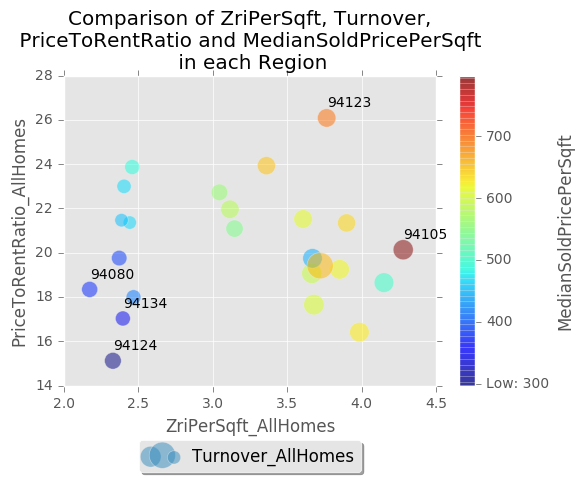

In [12]:
plt.scatter(avgHprice['ZriPerSqft_AllHomes'], avgHprice['PriceToRentRatio_AllHomes'], 
            alpha=0.5, 
            s=30*avgHprice['Turnover_AllHomes'], 
            c=avgHprice['MedianSoldPricePerSqft_AllHomes'],
           label='Turnover_AllHomes')
plt.xlabel('ZriPerSqft_AllHomes')
plt.ylabel('PriceToRentRatio_AllHomes')
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15),
          fancybox=True, shadow=True, ncol=5)
#plt.colorbar()
plt.title('Comparison of ZriPerSqft, Turnover,\n PriceToRentRatio and MedianSoldPricePerSqft \n in each Region')
cbar = plt.colorbar(ticks = [300,400,500,600,700,800,900])
cbar.ax.set_yticklabels(['Low: 300','400', '500','600', '700', '800','900'])
cbar.set_label(r'MedianSoldPricePerSqft');

for i, txt in zip(range(0,len(avgHprice['RegionName'])),avgHprice['RegionName']):
    if i in list([0,19,24,18,4]):
        plt.annotate(txt, (avgHprice['ZriPerSqft_AllHomes'].iloc[i],avgHprice['PriceToRentRatio_AllHomes'].iloc[i]+0.5))

In [13]:
avgHprice.iloc[[0,19,24,18,4]]

,RegionName,ZriPerSqft_AllHomes,MedianSoldPricePerSqft_AllHomes,PriceToRentRatio_AllHomes,Turnover_AllHomes
RegionName,,,,,
94080,94080,2.172000,375.629802,18.342105,4.413822
94124,94124,2.328160,297.008046,15.119605,4.810203
94134,94134,2.395173,347.027455,17.030000,3.852362
94123,94123,3.764773,696.166788,26.086711,5.839732
94105,94105,4.279173,798.257824,20.133816,6.928359


In [128]:
def draw_sf_zip(width=2e7,proj='merc'):
    figsize = [10,10]; dpi=80
    fig = plt.figure(1, figsize = figsize, dpi = dpi)
    ax = fig.add_subplot(111)
    bmap = Basemap(width=width,height=width,projection=proj,
                   llcrnrlon=-122.6,llcrnrlat=37.6,urcrnrlon=-122.3,urcrnrlat=37.9,
                   resolution='h', #f for full
                   lat_0 = 37.7,
                   lon_0=-122.4, ax = ax)
    bmap.drawcoastlines()
    bmap.drawmapboundary()
    bmap.readshapefile('cb_2015_us_zcta510_500k','zipcode')
    return ax, fig, bmap

In [23]:
def find(lst = bmap.zipcode_info[0:100], key="GEOID10", value=['84536','94929']):
    index = []
    for i, dic in enumerate(lst):
        if dic[key] in value:
            index.append(i)
    return index

In [24]:
list0=avgHprice['RegionName'].tolist()
list1=[]
for i in list0:
    list1.append(str(i))
    
Zindex = find(lst = bmap.zipcode_info[:], value =list1[:])

In [34]:
ax, fig, bmap = draw_sf_zip()
ax.set_title('SF divided by Zipcode')
list1[4] #list([0,19,24,18,4])

'94105'

In [130]:
def mapHprice(value = 'ZriPerSqft_AllHomes'):
    table0= avgHprice[[value,'RegionName']]
    table0 = table0.dropna()
    list0 = avgHprice['RegionName'].tolist()
    rank = ss.rankdata(avgHprice[value].tolist())
    n = len(rank)
    rank = rank/float(n)
    ax, fig, zmap = draw_sf_zip()
    for (i, z) in zip(range(0,25),Zindex):
        pp = Polygon(zmap.zipcode[z],facecolor=(1.,1.-rank[i]**2.,0.),
                 alpha=.3,zorder=1)
        ax.add_patch(pp)
        
        annotx =[]
        annoty =[]
        if i in list([0,19,24,18,4]): #add annotation to the most the least expensive region
            for t in zmap.zipcode[z][:]: #calculate the center of area in one region
                annotx.append(t[0]) 
                annoty.append(t[1])
            zipx = sum(annotx) / float(len(annotx))
            zipy = sum(annoty) / float(len(annoty))
        
            plt.annotate(list1[i], xy=(zipx-950,zipy),size=10,weight = 'black')
    
    plt.title(value + ' in SF')
    #plt.show()

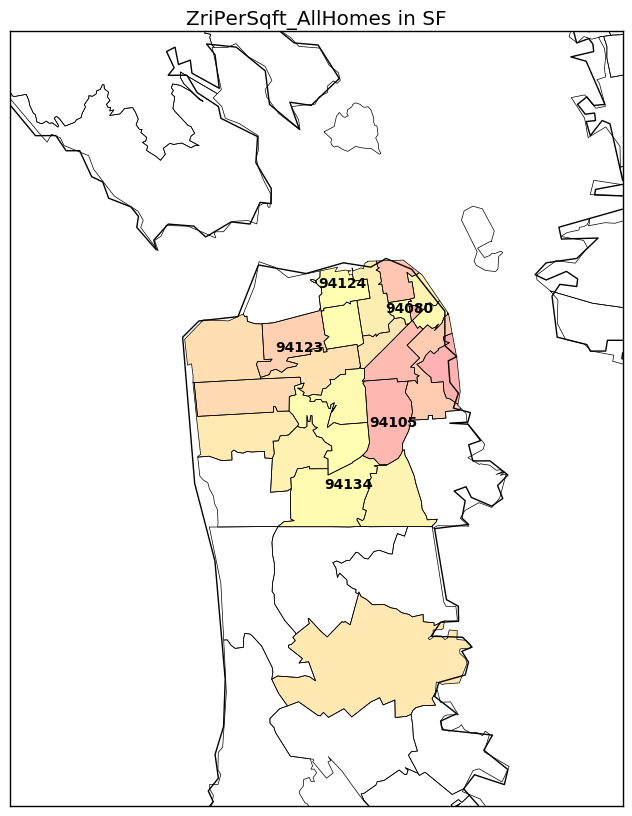

In [131]:
mapHprice()


plt.show()

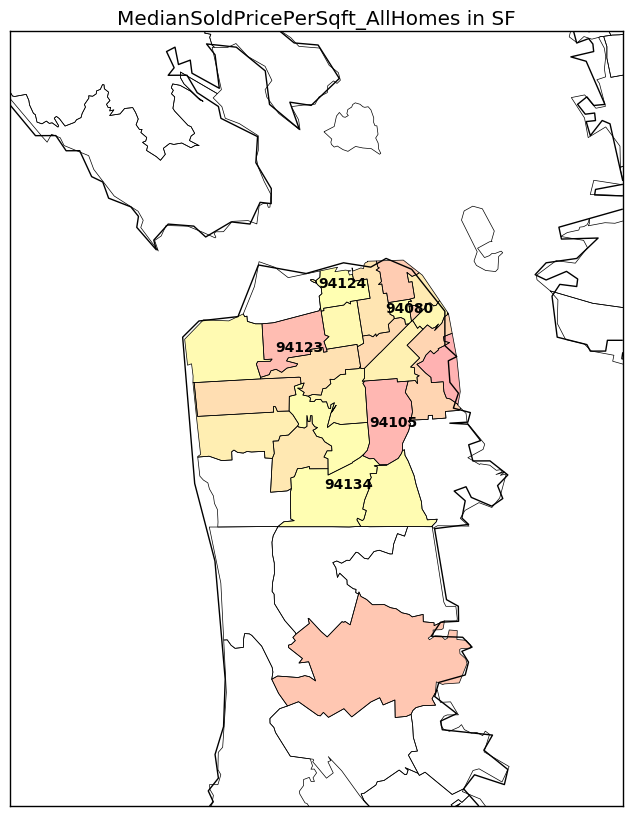

In [132]:
mapHprice('MedianSoldPricePerSqft_AllHomes')

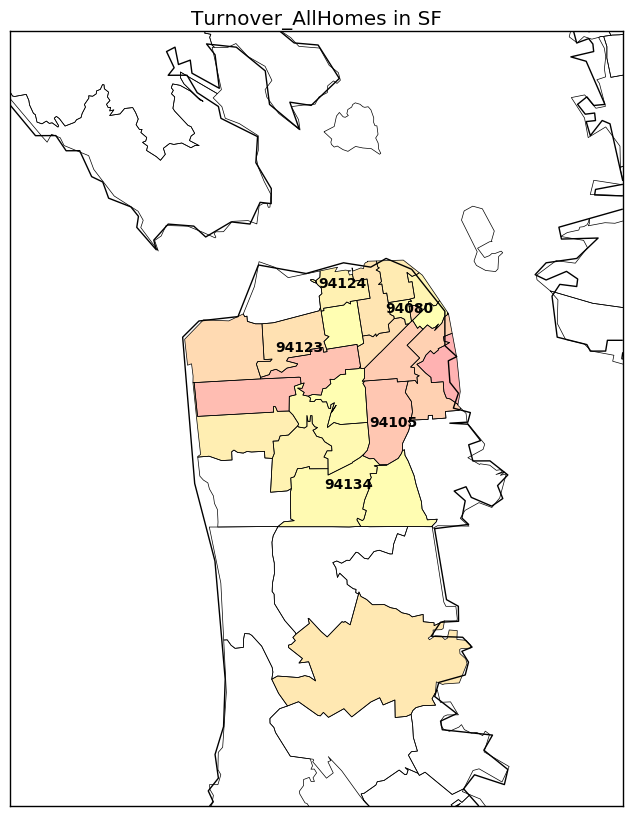

In [133]:
mapHprice('Turnover_AllHomes')
plt.show()

**1.2.2**-Which parts of the city are the most dangerous (and at what times)?

To find the most dangerous parts in the city, I mapped a heatmap of the crime number. As the plot below show, Southern dstrict is the most dangerous place in SF. The crime number is almost 200000. Also, by using the barplot, the crime number in Southern district is much higher than other district in SF.

In [56]:
Crime = pd.read_sql_query("select * from crime",conn0)

In [57]:
Crime.head()

,IncidntNum,Category,Descript,DayOfWeek,Datetime,PdDistrict,Resolution,Address,Lon,Lat
0,150060275,NON-CRIMINAL,LOST PROPERTY,Monday,2015-01-19 14:00:00,MISSION,NONE,18TH ST / VALENCIA ST,-122.421582,37.761701
1,150098210,ROBBERY,"ROBBERY, BODILY FORCE",Sunday,2015-02-01 15:45:00,TENDERLOIN,NONE,300 Block of LEAVENWORTH ST,-122.414406,37.784191
2,150098210,ASSAULT,AGGRAVATED ASSAULT WITH BODILY FORCE,Sunday,2015-02-01 15:45:00,TENDERLOIN,NONE,300 Block of LEAVENWORTH ST,-122.414406,37.784191
3,150098210,SECONDARY CODES,DOMESTIC VIOLENCE,Sunday,2015-02-01 15:45:00,TENDERLOIN,NONE,300 Block of LEAVENWORTH ST,-122.414406,37.784191
4,150098226,VANDALISM,"MALICIOUS MISCHIEF, VANDALISM OF VEHICLES",Tuesday,2015-01-27 19:00:00,NORTHERN,NONE,LOMBARD ST / LAGUNA ST,-122.431119,37.800469


In [135]:
def draw_sf(width=2e7,proj='merc'):
    figsize = [10,10]; dpi=80
    fig = plt.figure(1, figsize = figsize, dpi = dpi)
    ax = fig.add_subplot(111)
    bmap = Basemap(width=width,height=width,projection=proj,
                   llcrnrlon=-122.53,llcrnrlat=37.67,urcrnrlon=-122.33,urcrnrlat=37.85,
                   resolution='h', #f for full
                   lat_0 = 37.5,
                   lon_0=-122.5)
    bmap.drawcoastlines()
    bmap.drawmapboundary(fill_color='white')
    #bmap.fillcontinents(color='white',lake_color='white')
    bmap.readshapefile('geo_export_772ba198-1646-427d-8190-94c324b75364','SFFindNeighborhoods')
    return ax, fig, bmap

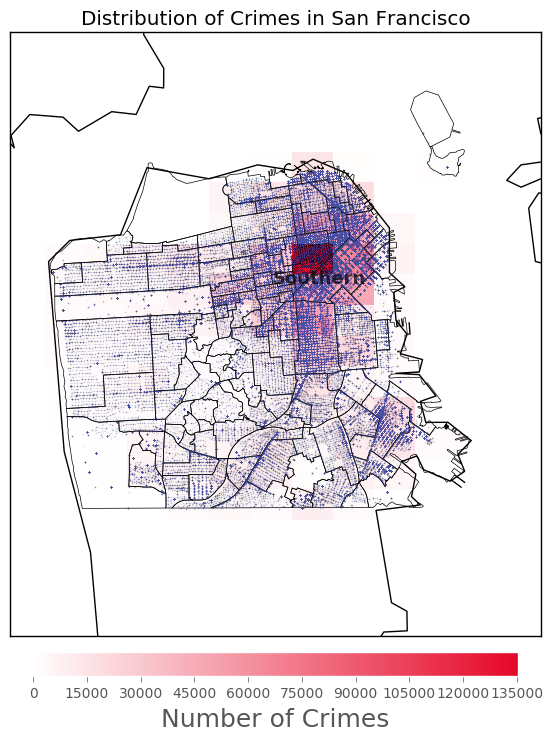

In [140]:
ax, fig, bmap = draw_sf()

lons = list(Crime['Lon'])
lats = list(Crime['Lat'])
x,y = bmap(lons, lats)
#bmap.plot(x, y, 'o', markersize=5 ,markeredgecolor="none", alpha=0.33)

db = 0.003 # bin padding
lon_bins = np.linspace(min(lons)-db, max(lons)+db, 10+1) # 10 bins
lat_bins = np.linspace(min(lats)-db, max(lats)+db, 13+1) # 13 bins
    
density, _, _ = np.histogram2d(lats, lons, [lat_bins, lon_bins])

# Turn the lon/lat of the bins into 2 dimensional arrays ready
# for conversion into projected coordinates
lon_bins_2d, lat_bins_2d = np.meshgrid(lon_bins, lat_bins)

# convert the bin mesh to map coordinates:
xs, ys = bmap(lon_bins_2d, lat_bins_2d) # will be plotted using pcolormesh
# ######################################################################

# define custom colormap, white -> nicered, #E6072A = RGB(0.9,0.03,0.16)
cdict = {'red':  ( (0.0,  1.0,  1.0),
                   (1.0,  0.9,  1.0) ),
         'green':( (0.0,  1.0,  1.0),
                   (1.0,  0.03, 0.0) ),
         'blue': ( (0.0,  1.0,  1.0),
                   (1.0,  0.16, 0.0) ) }
custom_map = LinearSegmentedColormap('custom_map', cdict)
plt.register_cmap(cmap=custom_map)


# add histogram squares and a corresponding colorbar to the map:
plt.pcolormesh(xs, ys, density, cmap="custom_map")

cbar = plt.colorbar(orientation='horizontal', shrink=0.625, aspect=20, fraction=0.2,pad=0.02)
cbar.set_label('Number of Crimes',size=18)
#plt.clim([0,100])


bmap.plot(x, y, 'o', markersize=1,#zorder=6, 
          markerfacecolor='#424FA4',markeredgecolor="none", alpha=0.03)
 
    
# http://matplotlib.org/basemap/api/basemap_api.html#mpl_toolkits.basemap.Basemap.drawmapscale
#bmap.drawmapscale(-119-6, 37-7.2, -119-6, 37-7.2, 500, barstyle='fancy', yoffset=20000)

plt.title('Distribution of Crimes in San Francisco')
plt.annotate('Southern', xy=bmap.SFFindNeighborhoods[21][1], 
             color ='black',weight = 'black', size = 13, alpha =0.7)

plt.show()

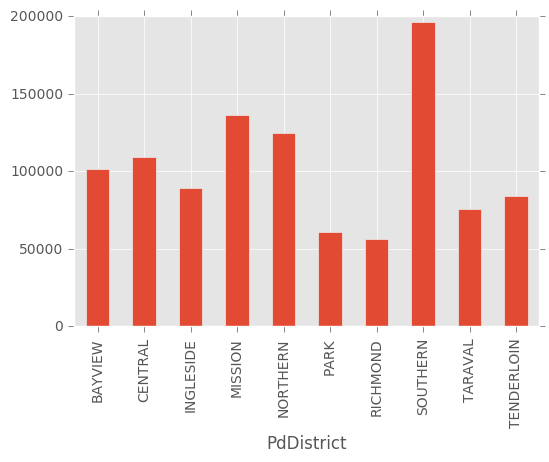

In [79]:
Crime.groupby(['PdDistrict']).size().plot(kind = 'Bar')

As for most dangerous time in SF, I ploted the histogram of crime case time.
From the histogram, it is clear that the most dangerous time in a day is around 6pm. Crime case number starts to increase from 5am and increases until 18-19pm, then drops.

In [81]:
times = pd.DatetimeIndex(Crime.Datetime)
grouped = Crime.groupby([times.hour, times.minute])

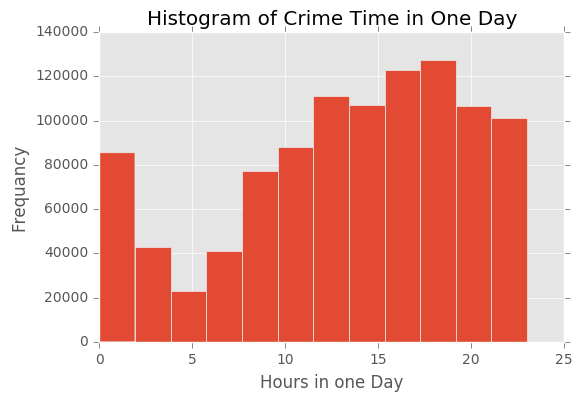

In [87]:
plt.hist(times.hour, bins = 12)
plt.title('Histogram of Crime Time in One Day')
plt.xlabel('Hours in one Day')
plt.ylabel('Frequancy')
plt.show()

**1.2.3** -Are noise complaints and mobile food vendors related?

The noise complaints are not very much related with mobile food vendors.

The barplot of noise complaints type shows that only few complaints is about mobile food vendors. Also, from the heatmap marking the noise number and vendors, we can see that the density of noise complaints are not very high associated with the distribution of vendors, especially in southern part of the city. Though in the areas where there are a lot of complaints, the number of vendors is large. However, it is not the opposite, in areas where there is a lot of vendors, the density of complaints are not always high. So the association between them is not very high.

In [91]:
c.execute("""select * from mobile_food_locations
""")
c.fetchone() 

(762182,
 u'TOWNSEND ST: 05TH ST to 06TH ST (400 - 499)',
 u'444 TOWNSEND ST',
 37.7748713162388,
 -122.39853170827601)

In [92]:
c.description

(('locationid', None, None, None, None, None, None),
 ('LocationDescription', None, None, None, None, None, None),
 ('Address', None, None, None, None, None, None),
 ('Latitude', None, None, None, None, None, None),
 ('Longitude', None, None, None, None, None, None))

In [5]:
Noise = pd.read_sql_query("select * from noise",conn0)

In [6]:
Noise = Noise.dropna()

In [7]:
Noise.head()

,CaseID,Type,Address,Neighborhood,Datetime,Lat,Lon
1,6446138,amplified_sound_electronics,Intersection of CLINTON PARK and GUERRERO ST,Mission Dolores,2016-10-21 13:20:18,37.769148,-122.424475
2,5929789,other_excessive_noise,"1301 48TH AVE, SAN FRANCISCO, CA, 94122",Outer Sunset,2016-06-01 11:38:59,37.762047,-122.508365
3,5659943,other_excessive_noise,"736 LEAVENWORTH ST, SAN FRANCISCO, CA, 94109",Lower Nob Hill,2016-03-13 01:18:27,37.787983,-122.414943
4,5930704,other_excessive_noise,"1360 43RD AVE, SAN FRANCISCO, CA, 94122",Outer Sunset,2016-06-01 13:58:43,37.761385,-122.502232
5,6427526,construction_private_property,"108 VIRGINIA AVE, SAN FRANCISCO, CA, 94110",Bernal Heights,2016-10-17 07:28:37,37.742435,-122.420087


In [8]:
Noise.groupby(['Type']).size()

Type
amplified_sound_electronics       449
construction_emergency             26
construction_private_property     711
construction_public               349
delivery_service_business          82
delivery_service_construction       6
delivery_service_vehicle           23
emergency_equipment                 9
entertainment                     301
garbage_recycling_collection      229
home_improvement_maintenance       29
hospital                            4
major_event_venue                 127
mechanical_equipment              318
mobile_food_facility                7
other_excessive_noise            1060
other_reallocate                  173
protest_speech_bullhorns            9
public_speech                       9
sirens                             37
tour_bus                           28
traffic                           195
vehicle_car_alarm                  56
vehicle_repair                     13
dtype: int64

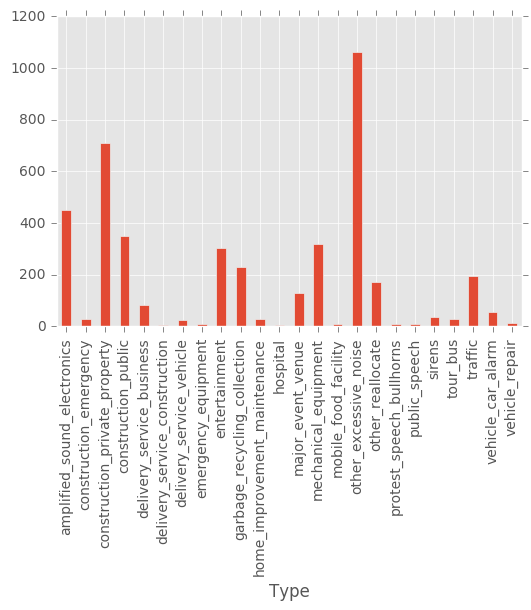

In [10]:
Noise.groupby(['Type']).size().plot(kind='Bar')

In [99]:
Vendors = pd.read_sql_query("select * from mobile_food_locations",conn0)

In [100]:
Vendors = Vendors.dropna()

In [101]:
Vendors.head()

,locationid,LocationDescription,Address,Latitude,Longitude
0,762182,TOWNSEND ST: 05TH ST to 06TH ST (400 - 499),444 TOWNSEND ST,37.774871,-122.398532
1,437211,MISSOURI ST: 20TH ST to SIERRA ST (500 - 630),555 MISSOURI ST,37.759304,-122.395902
2,765880,17TH ST: SAN BRUNO AVE to UTAH ST (2200 - 2299),2222 17TH ST,37.765216,-122.406007
3,765690,CESAR CHAVEZ ST: EVANS AVE to KANSAS ST (2100 ...,2323 CESAR CHAVEZ ST,37.748801,-122.400552
4,751253,FOLSOM ST: 14TH ST to 15TH ST (1800 - 1899),1800 FOLSOM ST,37.767852,-122.416105


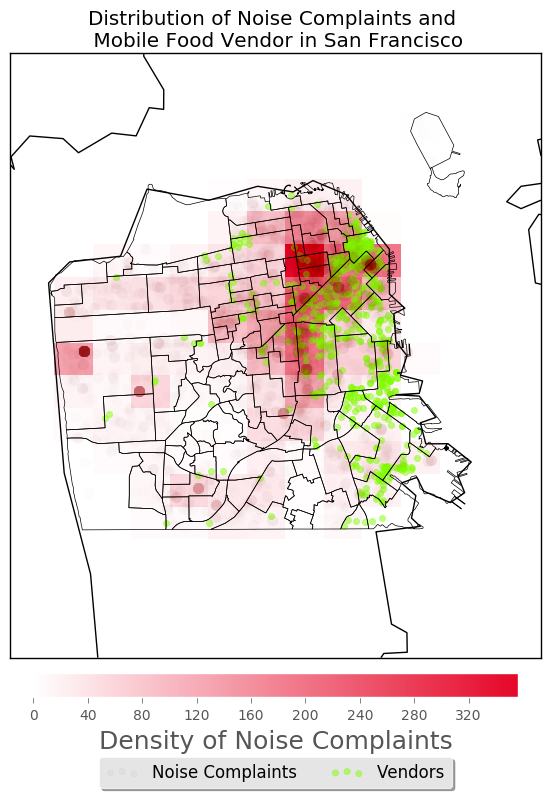

In [149]:
ax, fig, bmap = draw_sf()

lons = list(Noise['Lon'])
lats = list(Noise['Lat'])
x,y = bmap(lons, lats) #for density


lons1 = list(Vendors['Longitude'])
lats1 = list(Vendors['Latitude'])
x1,y1 = bmap(lons1, lats1) #for points


db = 0.003 # bin padding
lon_bins = np.linspace(min(lons)-db, max(lons)+db, 10+1) # 10 bins
lat_bins = np.linspace(min(lats)-db, max(lats)+db, 13+1) # 13 bins
    
density, _, _ = np.histogram2d(lats, lons, [lat_bins, lon_bins])

# Turn the lon/lat of the bins into 2 dimensional arrays ready
# for conversion into projected coordinates
lon_bins_2d, lat_bins_2d = np.meshgrid(lon_bins, lat_bins)

# convert the bin mesh to map coordinates:
xs, ys = bmap(lon_bins_2d, lat_bins_2d) # will be plotted using pcolormesh
# ######################################################################

# define custom colormap, white -> nicered, #E6072A = RGB(0.9,0.03,0.16)
cdict = {'red':  ( (0.0,  1.0,  1.0),
                   (1.0,  0.9,  1.0) ),
         'green':( (0.0,  1.0,  1.0),
                   (1.0,  0.03, 0.0) ),
         'blue': ( (0.0,  1.0,  1.0),
                   (1.0,  0.16, 0.0) ) }
custom_map = LinearSegmentedColormap('custom_map', cdict)
plt.register_cmap(cmap=custom_map)


# add histogram squares and a corresponding colorbar to the map:
plt.pcolormesh(xs, ys, density, cmap="custom_map")

cbar = plt.colorbar(orientation='horizontal', shrink=0.625, aspect=20, fraction=0.2,pad=0.02)
cbar.set_label('Density of Noise Complaints',size=18)
#plt.clim([0,100])


# translucent blue scatter plot of epicenters above histogram:    
#x,y = bmap(lons, lats)
bmap.plot(x, y, 'o', markersize=8,zorder=6, markerfacecolor='#990000',markeredgecolor="none", alpha=0.01)
    
# make image bigger:
#plt.gcf().set_size_inches(15,15)

plt.scatter(x[1], y[1], label = 'Noise Complaints',alpha = 0.5, color = '#990000')
plt.scatter(x1, y1, label = 'Vendors', alpha =0.5, color = '#80FF00')
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15),
          fancybox=True, shadow=True, ncol=5)
plt.title('Distribution of Noise Complaints and \n Mobile Food Vendor in San Francisco')
plt.show()

**1.2.4**-What are the best times and places to find food trucks?

To find out the best times and places to find food truck, I created tables of food truck schedule from mobile_food_schedule and mobile_food_locations. Then I selected truck information based on food trucks openning time, from 0-6am, 7-12pm, 13-18pm, and 19-24pm. I ploted the locations of food trucks by their openning time into SF map. 

On the map, in places around Potrero Hill and Dogpatch, I can basically find food trucks in all time slots. The marked place on the map is the best places to find food trucks

The best time to find food truck is during 7-12pm during one day.

In [204]:
c.execute("""select * from mobile_food_schedule""")
c.fetchone()

(305727, u'11MFF-0040', u'Mo', 15, 10)

In [221]:
c.execute("DROP TABLE Truck")

In [222]:
#create a table of permit, FacolotyType and locationid
c.execute("""CREATE TABLE Truck
as select * from mobile_food_schedule
join mobile_food_permits
on mobile_food_schedule.permit = mobile_food_permits.permit
where mobile_food_permits.FacilityType = 'Truck' and mobile_food_permits.Status = 'APPROVED' """)
c.fetchone()

In [225]:
c.execute("DROP TABLE LocTime1")

In [226]:
#LocTime1 is vendors open from 19 to 24
c.execute("""CREATE TABLE LocTime1
    AS SELECT * FROM  Truck 
    join mobile_food_locations 
    on Truck.locationid = mobile_food_locations.locationid 
    where (StartHour >19 and StartHour<=24) or (EndHour >19 and EndHour<=24) or (StartHour <19 and EndHour >=24)
""")
#c.execute("DROP TABLE LocTime1")

In [227]:
LocTime1 = pd.read_sql("SELECT * FROM LocTime1", conn0)

In [229]:
LocTime1 = LocTime1[(LocTime1.T !=float(0)).all()]

In [230]:
LocTime1.head()

,locationid,permit,DayOfWeek,EndHour,StartHour,permit:1,Status,Applicant,FacilityType,FoodItems,PriorPermit,Approved,Expiration,locationid:1,LocationDescription,Address,Latitude,Longitude
0,765940,16MFF-0071,Sa,20,7,16MFF-0071,APPROVED,San Pancho's Tacos,Truck,Tacos: Burritos: Quesadillas: Tortas: Nachos: ...,1,2016-03-15 12:00:00,2017-03-15 12:00:00,765940,ALEMANY BLVD: SICKLES AVE to I-280 N ON RAMP \...,3119 ALEMANY BLVD,37.710193,-122.455222
1,765940,16MFF-0071,Su,20,7,16MFF-0071,APPROVED,San Pancho's Tacos,Truck,Tacos: Burritos: Quesadillas: Tortas: Nachos: ...,1,2016-03-15 12:00:00,2017-03-15 12:00:00,765940,ALEMANY BLVD: SICKLES AVE to I-280 N ON RAMP \...,3119 ALEMANY BLVD,37.710193,-122.455222
12,762515,16MFF-0032,Fr,20,8,16MFF-0032,APPROVED,Tacos Rodriguez,Truck,Tacos: burritos: quesadillas: soda & water,1,2016-03-09 12:00:00,2017-03-15 12:00:00,762515,EVANS AVE: KEITH ST to MENDELL ST (1201 - 1399...,1275 EVANS AVE,37.739111,-122.382465
13,762515,16MFF-0032,Mo,20,8,16MFF-0032,APPROVED,Tacos Rodriguez,Truck,Tacos: burritos: quesadillas: soda & water,1,2016-03-09 12:00:00,2017-03-15 12:00:00,762515,EVANS AVE: KEITH ST to MENDELL ST (1201 - 1399...,1275 EVANS AVE,37.739111,-122.382465
14,762515,16MFF-0032,Sa,20,8,16MFF-0032,APPROVED,Tacos Rodriguez,Truck,Tacos: burritos: quesadillas: soda & water,1,2016-03-09 12:00:00,2017-03-15 12:00:00,762515,EVANS AVE: KEITH ST to MENDELL ST (1201 - 1399...,1275 EVANS AVE,37.739111,-122.382465


In [231]:
c.execute("DROP TABLE LocTime2")

In [232]:
c.execute("DROP TABLE LocTime3")

In [233]:
c.execute("DROP TABLE LocTime4")

In [234]:
#LocTime2 is vendors open from 13 to 18
c.execute("""CREATE TABLE LocTime2
    AS SELECT * FROM  Truck 
    join mobile_food_locations 
    on Truck.locationid = mobile_food_locations.locationid 
    where (StartHour >13 and StartHour<=18) or (EndHour >13 and EndHour<=18) or (StartHour <13 and EndHour >=18)
""")
#c.execute("DROP TABLE LocTime1")
LocTime2 = pd.read_sql("SELECT * FROM LocTime2", conn0)
LocTime2 = LocTime2[(LocTime2.T !=float(0)).all()]

In [235]:
#LocTime3 is vendors open from 7 to 12
c.execute("""CREATE TABLE LocTime3
    AS SELECT * FROM  Truck 
    join mobile_food_locations 
    on Truck.locationid = mobile_food_locations.locationid 
    where (StartHour >7 and StartHour<=12) or (EndHour >7 and EndHour<=12) or (StartHour <7 and EndHour >=12)
""")
#c.execute("DROP TABLE LocTime1")
LocTime3 = pd.read_sql("SELECT * FROM LocTime3", conn0)
LocTime3 = LocTime3[(LocTime3.T !=float(0)).all()]

In [236]:
#LocTime4 is vendors open from 0 to 6
c.execute("""CREATE TABLE LocTime4
    AS SELECT * FROM  Truck 
    join mobile_food_locations 
    on Truck.locationid = mobile_food_locations.locationid 
    where (StartHour >0 and StartHour<=6) or (EndHour >0 and EndHour<=6) or (StartHour <0 and EndHour >=6)
""")
#c.execute("DROP TABLE LocTime1")
LocTime4 = pd.read_sql("SELECT * FROM LocTime4", conn0)
LocTime4 = LocTime4[(LocTime4.T !=float(0)).all()]

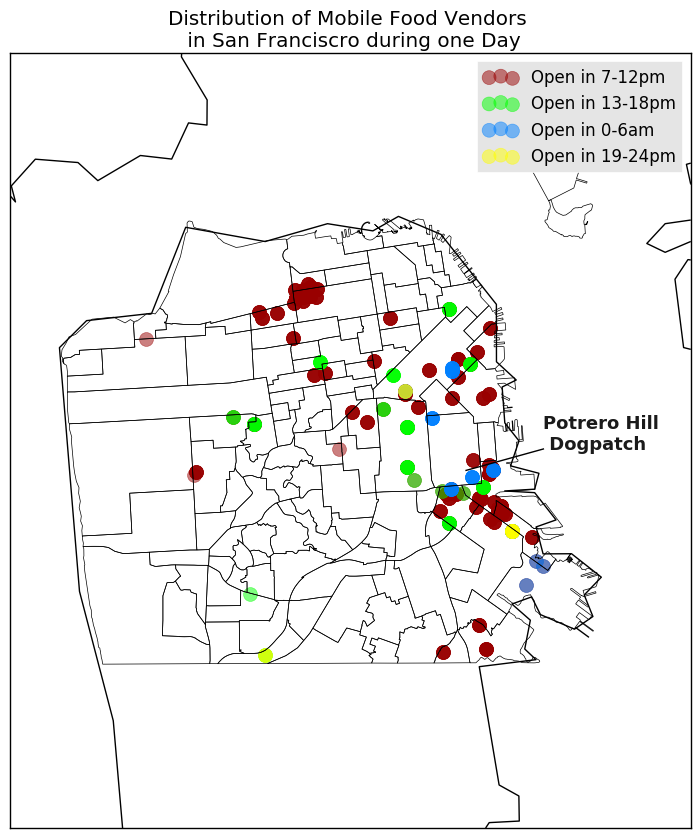

In [291]:
size = 100
a =0.5
ax, fig, bmap = draw_sf()

lons3 = list(LocTime3['Longitude'])
lats3 = list(LocTime3['Latitude'])
x3,y3 = bmap(lons3, lats3) #for points
#bmap.plot(x1, y1, 'o', markersize=10,#zorder=6, markerfacecolor='#990000',markeredgecolor="none", alpha=0.15)
plt.scatter(x3, y3, label = 'Open in 7-12pm', alpha =a, color = '#990000', s =size)

lons2 = list(LocTime2['Longitude'])
lats2 = list(LocTime2['Latitude'])
x2,y2 = bmap(lons2, lats2) #for points
plt.scatter(x2, y2, label ='Open in 13-18pm', alpha =a, color = '#00ff00', s =size)

lons4 = list(LocTime4['Longitude'])
lats4 = list(LocTime4['Latitude'])
x4,y4 = bmap(lons4, lats4) #for points
plt.scatter(x4, y4, label = 'Open in 0-6am', alpha =a, color = '#0080ff', s =size)

lons1 = list(LocTime1['Longitude'])
lats1 = list(LocTime1['Latitude'])
x1,y1 = bmap(lons1, lats1) #for points
plt.scatter(x1, y1, label = 'Open in 19-24pm', alpha =a, color = '#ffff00', s =size)

plt.annotate('Potrero Hill\n Dogpatch ', xy = (max(x4), y4[1]+700), 
             color ='black',weight = 'black', size = 13, alpha =0.9)
plt.plot([min(x4)+2000, max(x4)], [y4[1],y4[1]+700], c = 'black')
plt.legend()
plt.title('Distribution of Mobile Food Vendors \n in San Franciscro during one Day')
plt.show()

**1.2.5**-Is there a relationship between housing prices and any of the other tables?

Relating previous maps to the housing price, it is easy to find that the places where crime rate and the number of noise complaints are low, the housing prices are high. Housing price is not very much related with the the number and availability of vendors. Now let's look the relationship between housing price and other tables.

By plotting the distribution map of parks, schools and parkings on the heatmap of SF housing price, we can see that the housing prices are high in places where there are many parks and schools. The housing prices are relatively low if there are many parkings.

In [314]:
Parks = pd.read_sql("SELECT * FROM parks", conn0).dropna()

In [305]:
c.execute("select * from zillow")
c.description

(('RegionName', None, None, None, None, None, None),
 ('Date', None, None, None, None, None, None),
 ('ZriPerSqft_AllHomes', None, None, None, None, None, None),
 ('MedianSoldPricePerSqft_AllHomes', None, None, None, None, None, None),
 ('PriceToRentRatio_AllHomes', None, None, None, None, None, None),
 ('Turnover_AllHomes', None, None, None, None, None, None))

In [318]:
Parks['Parks']= pd.Series('NA', index=Parks.index)
Parks.head()

,Name,Type,Acreage,ParkID,Lat,Lon,Parks
0,10TH AVE/CLEMENT MINI PARK,Mini Park,0.66,156,37.781844,-122.468099,NA
1,15TH AVENUE STEPS,Mini Park,0.26,185,37.759565,-122.472268,NA
2,24TH/YORK MINI PARK,Mini Park,0.12,51,37.753060,-122.408575,NA
3,29TH/DIAMOND OPEN SPACE,Neighborhood Park or Playground,0.82,194,37.743602,-122.435236,NA
4,ADAM ROGERS PARK,Neighborhood Park or Playground,2.74,46,37.731016,-122.383855,NA


In [322]:
list(Parks.columns.values)

['Name', 'Type', 'Acreage', 'ParkID', 'Lat', 'Lon', 'Parks']

In [379]:
def Hprice_factor(value = 'MedianSoldPricePerSqft_AllHomes', factor = Parks, alpha0 = 0.33, size=8):
    table0= avgHprice[[value,'RegionName']]
    table0 = table0.dropna()
    list0 = avgHprice['RegionName'].tolist()
    rank = ss.rankdata(avgHprice[value].tolist())
    n = len(rank)
    rank = rank/float(n)
    ax, fig, zmap = draw_sf_zip()
    
    lons = list(factor['Lon'])
    lats = list(factor['Lat'])
    x,y = zmap(lons, lats) #mark parks
    zmap.plot(x, y, 'o', markersize=size ,markerfacecolor='#ff0000' ,
              markeredgecolor="none", alpha=0.33)
    plt.scatter(x[1], y[1], label = list(factor.columns.values)[-1], alpha =0.8,s =50, color = '#990000')
    
    for (i, z) in zip(range(0,25),Zindex):
        pp = Polygon(zmap.zipcode[z],facecolor=(1.,1.-rank[i]**2.,0.),
                 alpha=.3,zorder=1)
        ax.add_patch(pp)
        
        annotx =[]
        annoty =[]
        if i in list([0,19,24,18,4]): #add annotation to the most the least expensive region
            for t in zmap.zipcode[z][:]: #calculate the center of area in one region
                annotx.append(t[0]) 
                annoty.append(t[1])
            zipx = sum(annotx) / float(len(annotx))
            zipy = sum(annoty) / float(len(annoty))
        
            plt.annotate(list1[i], xy=(zipx-950,zipy),size=10,weight = 'black')
    

    plt.legend()
    
    
    plt.title(value + ' \n and Number of ' + list(factor.columns.values)[-1] + ' in SF')
    plt.show()
    #return ax, fig, zmap

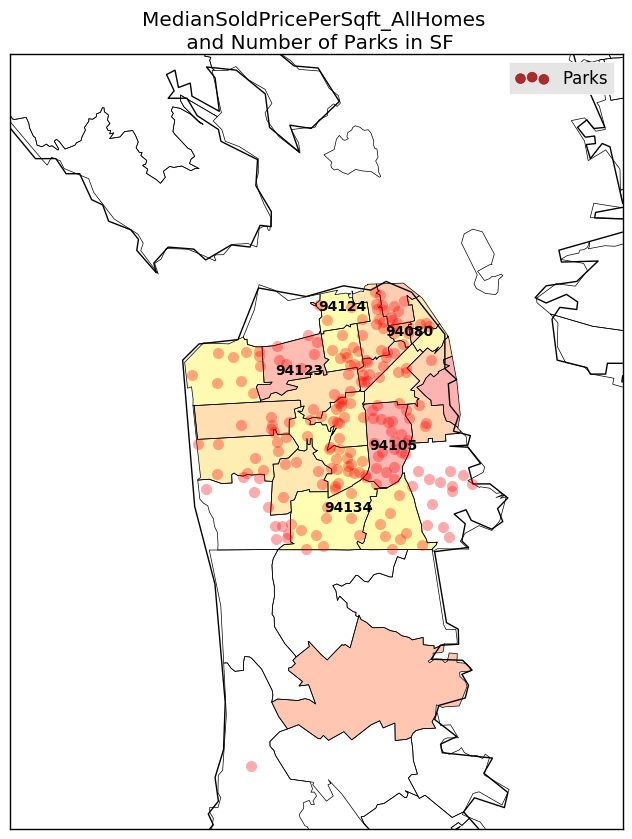

In [381]:
Hprice_factor()

In [372]:
Schools = pd.read_sql("SELECT * FROM schools", conn0).dropna()
Schools['Schools']= pd.Series('NA', index=Schools.index)
Schools.head()

,Name,Entity,LowerGrade,UpperGrade,GradeRange,Category,LowerAge,UpperAge,GeneralType,Address,Lat,Lon,Schools
0,Alamo Elementary School,SFUSD,0,5,K-5,USD Grades K-5,5,10,PS,"250 23RD AVE, San Francisco, CA 94121",37.783005,-122.482300,NA
1,Alvarado Elementary School,SFUSD,0,5,K-5,USD Grades K-5,5,10,PS,"625 DOUGLASS ST, San Francisco, CA 94114",37.753681,-122.438194,NA
2,Aptos Middle School,SFUSD,6,8,6-8,USD Grades 6-8,11,13,PS,"105 APTOS AVE, San Francisco, CA 94127",37.729672,-122.465782,NA
3,Argonne Early Education School,SFUSD,-2,0,PK-TK,USD PreK/TK,3,5,PS,"750 16TH AVE, San Francisco, CA 94118",37.773968,-122.474060,NA
4,Argonne Elementary School,SFUSD,0,5,K-5,USD Grades K-5,5,10,PS,"680 18TH AVE, San Francisco, CA 94121",37.775307,-122.476311,NA


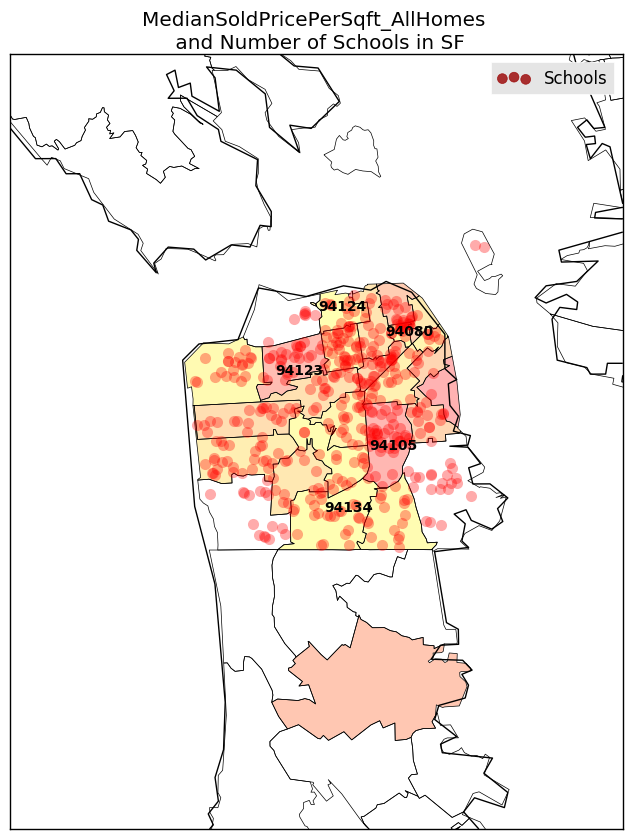

In [382]:
Hprice_factor(value = 'MedianSoldPricePerSqft_AllHomes', factor = Schools, alpha0=0.05)

In [366]:
Parkings = pd.read_sql("SELECT * FROM parking", conn0).dropna()
Parkings['Parkings']= pd.Series('NA', index=Parkings.index)
Parkings.head()

,Owner,Address,PrimeType,SecondType,GarOrLot,RegCap,ValetCap,MCCap,LandType,Lat,Lon,Parkings
0,Private,2110 Market St,PPA,,L,13,0,0,restaurant,37.767378,-122.429344,NA
1,SFMTA,993 Potrero,PPA,,L,34,0,0,,37.757272,-122.406320,NA
2,Port of SF,601 Terry A Francois Blvd,PPA,,L,72,0,0,,37.770135,-122.385801,NA
3,Private,11 SOUTH VAN NESS,PHO,CPO,G,130,0,0,,37.774150,-122.418402,NA
4,Private,101 CALIFORNIA ST,PPA,,G,250,0,0,,37.793243,-122.397495,NA


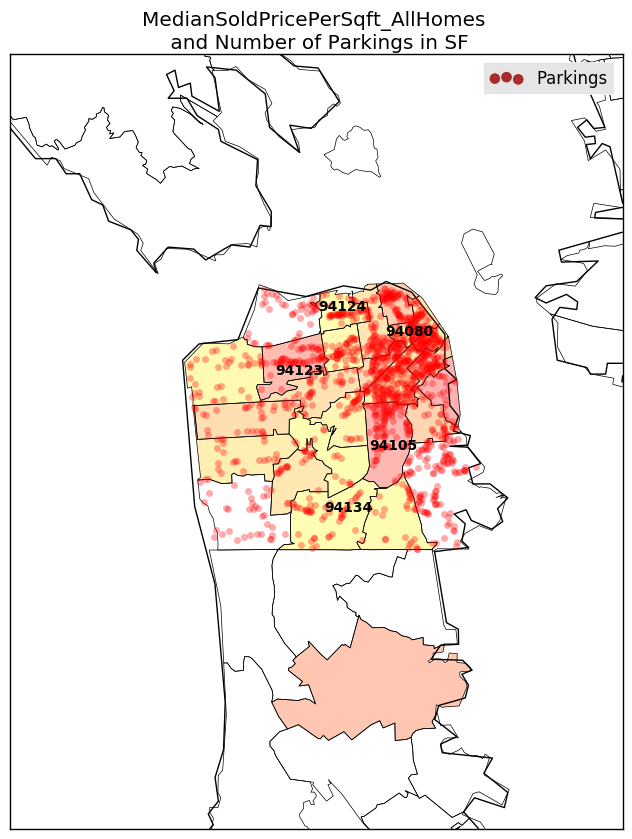

In [383]:
Hprice_factor(factor = Parkings, alpha0 = 0.005, size=5)